In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline

from time import time
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from PIL import Image
import cv2

import h5py

from multiprocessing import Pool as ThreadPool

In [2]:
file_path = "/home/amitp/Documents/Python/Training Orientation Detection/training_dataset_all_doric_cabled.h5"
with h5py.File(file_path,'r') as f:
    data = f['/frames'][:322280]
#for i in range(len(data)):
#    cv2.fastNlMeansDenoising(data[i],data[i],h=3,searchWindowSize=7,templateWindowSize=5)
#    if(i%1000==0):
#        print("\rProgress: {}%     ".format(i*100/len(data)), end='')

In [3]:
def RotateFrame(args):
    i=args[0]
    frame=args[1]
    a = angles[i]
    rotated=np.array(Image.fromarray(frame).rotate(a))
    noise=np.abs(np.random.normal(0,10,(80,80))).astype(np.uint8)
    return np.array(rotated)+noise
angles = np.load('/home/amitp/Documents/Python/Training Orientation Detection/angles.npy')
pool = ThreadPool(8)
i=0
for val in tqdm(pool.imap(RotateFrame,list(enumerate(data))), total=len(data)):
    data[i]=val
    i+=1
pool.close()
pool.join()

In [4]:
def getAccuracy(predictions,reference):
    acc = np.ndarray(predictions.shape)
    for i in range(len(predictions)):
        err = abs(predictions[i]-reference[i])
        if(err<15 or err>165):
            if err>165:
                predictions[i]=180-predictions[i]
            acc[i]=1
        else:
            acc[i]=0
    return(np.mean(acc))

In [5]:
def OrientationFromImage(frame):
    #T,im = cv2.threshold(frame,thresh,255,cv2.THRESH_BINARY)
    im= cv2.adaptiveThreshold(frame,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,91,1)
    im = cv2.erode(im,kernel = np.ones((11,11),np.uint8),iterations = 1)
    im = cv2.dilate(im,kernel = np.ones((4,4),np.uint8),iterations = 1)
    _,contours,_=cv2.findContours(im,2,2)
    if(len(contours)>0):
        cnt = contours[0]
        moments = cv2.moments(cnt)
        angle = -0.5*np.arctan2(2*moments["mu11"],moments["mu20"]-moments["mu02"])
        angle =angle*180/np.pi
        if(angle<0):
            angle=180+angle
        return angle
    else:
        return 0

In [6]:
predics= np.zeros(len(data))
pool = ThreadPool(8)
i=0
for val in tqdm(pool.imap(OrientationFromImage,data,chunksize=100), total=len(data)):
    predics[i]=val
    i+=1
pool.close()
pool.join()
print(getAccuracy(predics,angles))


0.9821521658185429


In [ ]:
neural_predics = np.load('/home/amitp/Documents/Python/Training Orientation Detection/neural_net.npy')
print(getAccuracy(predics,angles))
print(getAccuracy(neural_predics,angles))

In [ ]:
#ip_error = abs(angles-predics)
nn_error = abs(angles-neural_predics)
#diff_error = abs(nn_error-ip_error)
outliers = np.ndarray(1)
threshold=140
sortedIdx = np.argsort(ip_error)[::-1]
#sortedIdx=sortedIdx[ip_error[sortedIdx]<threshold]
i = 0
imgDbg=True
for j in range(0,10):
    plt.figure(j)
    #while nn_error[sortedIdx[i]] > 15:# or ip_error[sortedIdx[i]]>threshold:
    #    i+=1
    if imgDbg:
        plt.imshow(imageDebug(data[sortedIdx[i]]))
    else:
        plt.imshow(data[sortedIdx[i]])
    plt.text(2,4,ip_error[sortedIdx[i]],bbox=dict(facecolor='white', alpha=0.5))
    plt.text(2,10,predics[sortedIdx[i]],bbox=dict(facecolor='white', alpha=0.5))
    plt.text(2,16,sortedIdx[i],bbox=dict(facecolor='white', alpha=0.5))
    plt.show()
    i+=1
fig=plt.figure()
plt.plot(ip_error)#,'b.',label="IP Error")
plt.plot(nn_error)#,'r.',label="NN Error")
#plt.plot(diff_error)
fig.suptitle('Graphing Error', fontsize=20)
plt.xlabel('# of Samples', fontsize=14)
plt.ylabel('Error (deg)', fontsize=14)
plt.legend()
plt.xlim(0,1000)
plt.show()
fig.savefig('error.png')

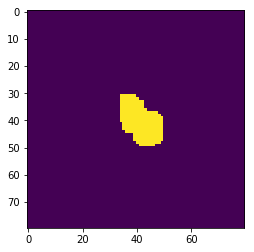

128.81102140992266
122.72765383862702


In [7]:
def imageDebug(frame):
    #T,im = cv2.threshold(frame,thresh,255,cv2.THRESH_BINARY)
    im= cv2.adaptiveThreshold(frame,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,91,1)
    im = cv2.erode(im,kernel = np.ones((11,11),np.uint8),iterations = 1)
    im = cv2.dilate(im,kernel = np.ones((4,4),np.uint8),iterations = 1)
    _,contours,_=cv2.findContours(im,2,2)
    #cv2.drawContours(im, contours, -1, 128, 3)
    return im
    if(len(contours)>0):
        cnt = contours[0]
        moments = cv2.moments(cnt)
        angle = -0.5*np.arctan2(2*moments["mu11"],moments["mu20"]-moments["mu02"])
        angle =angle*180/np.pi
        if(angle<0):
            angle=180+angle
        return angle
    else:
        return 0
which_index=1
plt.imshow(imageDebug(data[which_index]))
plt.show()

print(predics[which_index])
print(angles[which_index])

In [ ]:
print(np.mean(ip_error),np.mean(nn_error))

In [ ]:
unique, counts = np.unique(np.sum(data,axis=(1,2)), return_counts=True)
dict(zip(unique, counts))[0]

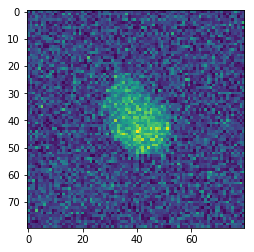

NameError: name 'imageDebug' is not defined

In [8]:
noise=np.abs(np.random.normal(0,10,(80,80))).astype(np.uint8)
toShow=(data[1]+noise)
plt.imshow(toShow)
plt.show()
toShow=imageDebug(toShow)
plt.imshow(toShow)
plt.show()